# Deep Learning Assignment 2

Constructing two different baseline architectures: BiLSTM and Attention-pooled BiGRU to predict semantic similarity between legal clauses.


## 1. Imports & Global Setup


In [ ]:
import random
import os
import time
import copy
import re
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, auc, confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

SEED = 67
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

def _get_mps_preferred_device():
    try:
        mps = getattr(torch.backends, "mps", None)
        if mps is not None and mps.is_available() and mps.is_built():
            return torch.device("mps")
    except Exception:
        pass
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = _get_mps_preferred_device()
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

print("Using device:", device)

Using device: mps


## 2. Clause-Level Splits & Pair Sampling

We first load every clause text per category, split the _clauses_ into train/val/test buckets, and only then form positive/negative clause pairs within each split to avoid leakage.


In [ ]:
# --- Clause-level split + pair building ---
DATA_DIR = Path('nlp_dataset')
MIN_CLAUSES_PER_LABEL = 2
NEG_POS_RATIO = 1.0
POSITIVE_PAIRS_PER_CLAUSE = 1

HEADER_PREFIX_RE = re.compile(r'^[a-z\s\.\-]{1,40}:?\s+', re.IGNORECASE)


def strip_clause_heading(text: str) -> str:
    text = (text or '').strip()
    cleaned = HEADER_PREFIX_RE.sub('', text)
    return cleaned if cleaned else text


def normalize_clause(text: str) -> str:
    stripped = strip_clause_heading(text)
    stripped = re.sub(r'\s+', ' ', stripped.lower())
    return stripped


rng = random.Random(SEED)


# 1) Load clauses per label (prefer in-file clause_type column when present)
label_to_texts = {}
for file in sorted(DATA_DIR.glob('*.csv')):
    df = pd.read_csv(file).dropna(subset=['clause_text'])
    df['clause_text'] = df['clause_text'].astype(str).apply(strip_clause_heading)
    df = df[df['clause_text'].str.len() > 0]
    label_col = 'clause_type' if 'clause_type' in df.columns else None
    if label_col:
        for lab, group in df.groupby(label_col):
            texts = group['clause_text'].tolist()
            if len(texts) >= MIN_CLAUSES_PER_LABEL:
                label_to_texts.setdefault(str(lab), []).extend(texts)
    else:
        if len(df) >= MIN_CLAUSES_PER_LABEL:
            label_to_texts[file.stem] = df['clause_text'].tolist()

seen = set()
for lab, texts in list(label_to_texts.items()):
    uniq = []
    for text in texts:
        key = normalize_clause(text)
        if key not in seen:
            seen.add(key)
            uniq.append(text)
    label_to_texts[lab] = uniq

labels = sorted(label_to_texts)
print(f"Clause categories: {len(labels)}; total clauses: {sum(len(v) for v in label_to_texts.values()):,}")


# 2) Split at the clause level per label
def split_texts(texts):
    texts = list(texts)
    if len(texts) < 4:
        return texts, [], []
    tr, temp = train_test_split(texts, test_size=0.3, random_state=SEED)
    if len(temp) < 2:
        return tr, temp, []
    va, te = train_test_split(temp, test_size=0.5, random_state=SEED)
    return tr, va, te


split = {'train': {}, 'val': {}, 'test': {}}
split_stats = {}
for lab in labels:
    tr, va, te = split_texts(label_to_texts[lab])
    split['train'][lab] = tr
    split['val'][lab] = va
    split['test'][lab] = te

for name, bucket in split.items():
    clauses = sum(len(v) for v in bucket.values())
    label_count = sum(1 for v in bucket.values() if len(v) > 0)
    split_stats[name] = {'clauses': clauses, 'labels': label_count}
    print(f"{name.title()} split: {clauses:,} clauses across {label_count:,} labels")


# 3) Build balanced pairs within each split
def build_pairs_for_split(bucket):
    labs = [lab for lab, texts in bucket.items() if len(texts) > 0]
    pos, neg = [], []
    for lab in labs:
        texts = bucket[lab]
        if len(texts) < 2:
            continue
        for clause in texts:
            for _ in range(POSITIVE_PAIRS_PER_CLAUSE):
                partner = rng.choice(texts)
                while partner == clause and len(texts) > 1:
                    partner = rng.choice(texts)
                pos.append((clause, partner, 1))
    num_neg = int(len(pos) * NEG_POS_RATIO)
    for _ in range(num_neg):
        la, lb = rng.sample(labs, 2)
        a = rng.choice(bucket[la]) if bucket[la] else None
        b = rng.choice(bucket[lb]) if bucket[lb] else None
        if a and b:
            neg.append((a, b, 0))
    pairs = pos + neg
    rng.shuffle(pairs)
    return pd.DataFrame(pairs, columns=['text_a', 'text_b', 'label'])


def encode_split(bucket):
    return build_pairs_for_split(bucket).reset_index(drop=True)


train_df = encode_split(split['train'])
val_df = encode_split(split['val'])
test_df = encode_split(split['test'])
pair_counts = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}
print(f"Pair counts -> train: {pair_counts['train']:,}, val: {pair_counts['val']:,}, test: {pair_counts['test']:,}")
print(f"Negative/positive ratio: {NEG_POS_RATIO}:1")
train_df.head()

Clause categories: 395; total clauses: 145,812
Train split: 101,905 clauses across 394 labels
Val split: 21,846 clauses across 394 labels
Test split: 22,061 clauses across 394 labels
Pair counts -> train: 203,810, val: 43,692, test: 44,122
Negative/positive ratio: 1.0:1


,text_a,text_b,label
0,"Employee's employment is terminated without ""c...",that any Mortgage Loans become delinquent in t...,1
1,"waiver of any term, provision or condition of ...","Agreement, any other Loan Document, nor any te...",1
2,"agreements herein, on the part of Lessee to be...","covenants herein set forth, the parties agree ...",1
3,the Authorized Participant’s acceptance of an ...,the several paragraphs of this Agreement are i...,0
4,(a) In the event a Change in Control of the Co...,"Change in Control, any portion of the Restrict...",1


## 3. Tokenization & Numericalization


In [11]:
TOKEN_PATTERN = re.compile(r"[A-Za-z']+")

def tokenize(text: str):
    return TOKEN_PATTERN.findall(text.lower())

counter = Counter()
for text in pd.concat([train_df['text_a'], train_df['text_b']]):
    counter.update(tokenize(text))

MAX_VOCAB = 30000
most_common = counter.most_common(MAX_VOCAB - 2)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
PAD_IDX = 0
UNK_IDX = 1
MAX_SEQ_LEN = 150

print('Vocab size:', len(vocab) + 2)
print('Top tokens:', counter.most_common(10))

Vocab size: 30000
Top tokens: [('the', 2981944), ('of', 1904838), ('or', 1458927), ('and', 1376200), ('to', 1313033), ('any', 891085), ('in', 863632), ('shall', 510768), ('be', 498965), ('a', 494305)]


In [12]:
def encode(text: str):
    tokens = tokenize(text)
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens][:MAX_SEQ_LEN]
    if len(ids) < MAX_SEQ_LEN:
        ids += [PAD_IDX] * (MAX_SEQ_LEN - len(ids))
    return ids


def encode_dataframe(df):
    left = np.array([encode(t) for t in df['text_a']], dtype=np.int64)
    right = np.array([encode(t) for t in df['text_b']], dtype=np.int64)
    labels = df['label'].astype(np.float32).values
    return left, right, labels

train_left, train_right, train_labels = encode_dataframe(train_df)
val_left, val_right, val_labels = encode_dataframe(val_df)
test_left, test_right, test_labels = encode_dataframe(test_df)
print('Encoded shapes ->', train_left.shape, val_left.shape, test_left.shape)

Encoded shapes -> (203810, 150) (43692, 150) (44122, 150)


## 4. PyTorch Datasets & Loaders


In [13]:
class PairDataset(Dataset):
    def __init__(self, left, right, labels):
        self.left = left
        self.right = right
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.left[idx], dtype=torch.long),
            torch.tensor(self.right[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )


TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
max_workers = min(4, os.cpu_count() or 1)
# Notebook-defined datasets cannot be pickled under spawn (macOS default), so default to serial loading.
num_workers = 0
loader_kwargs = {
    'num_workers': num_workers,
    'pin_memory': False,
    'persistent_workers': False
}

train_loader = DataLoader(
    PairDataset(train_left, train_right, train_labels),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    **loader_kwargs
)
val_loader = DataLoader(
    PairDataset(val_left, val_right, val_labels),
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    **loader_kwargs
)
test_loader = DataLoader(
    PairDataset(test_left, test_right, test_labels),
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    **loader_kwargs
)

## 5. Training Utilities & Early Stopping


In [14]:
criterion = nn.BCEWithLogitsLoss()


def _synchronize_if_needed():
    if device.type == 'mps' and hasattr(torch, 'mps'):
        try:
            torch.mps.synchronize()
        except Exception:
            pass


def elapsed_since(start_time: float) -> float:
    _synchronize_if_needed()
    return time.time() - start_time


def compute_metrics(probs, targets, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='binary', zero_division=0
    )
    try:
        roc = roc_auc_score(targets, probs)
    except ValueError:
        roc = float('nan')
    prec_curve, rec_curve, _ = precision_recall_curve(targets, probs)
    pr_auc = auc(rec_curve, prec_curve)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc,
        'pr_auc': pr_auc
    }


def find_best_threshold(probs, targets, default=0.5):
    precision, recall, thresholds = precision_recall_curve(targets, probs)
    if thresholds.size == 0:
        return default
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    candidate_scores = np.where(np.isfinite(f1_scores[:-1]), f1_scores[:-1], -np.inf)
    best_idx = int(np.argmax(candidate_scores))
    if candidate_scores[best_idx] == -np.inf:
        return default
    return float(thresholds[best_idx])


def run_epoch(model, loader, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    probs_list, targets_list = [], []
    for left, right, labels in loader:
        left = left.to(device)
        right = right.to(device)
        labels = labels.to(device)
        logits = model(left, right).squeeze(1)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
        total_loss += loss.item() * labels.size(0)
        probs_list.append(torch.sigmoid(logits).detach().cpu().numpy())
        targets_list.append(labels.detach().cpu().numpy())
    probs_all = np.concatenate(probs_list)
    targets_all = np.concatenate(targets_list)
    metrics = compute_metrics(probs_all, targets_all)
    return total_loss / len(loader.dataset), metrics


def train_model(model, train_loader, val_loader, epochs=12, lr=1e-3, weight_decay=1e-4, patience=3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = []
    best_state, best_f1 = None, -1
    epochs_without_improve = 0
    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = run_epoch(model, train_loader, optimizer)
        val_loss, val_metrics = run_epoch(model, val_loader)
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        })
        if val_metrics['f1'] > best_f1 + 1e-4:
            best_f1 = val_metrics['f1']
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_metrics['f1']:.4f}")
        if epochs_without_improve >= patience:
            print('Early stopping triggered.')
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


def predict_probs(model, loader):
    model.eval()
    probs, targets = [], []
    with torch.no_grad():
        for left, right, y in loader:
            left, right = left.to(device), right.to(device)
            logits = model(left, right).squeeze(1)
            probs.append(torch.sigmoid(logits).cpu().numpy())
            targets.append(y.numpy())
    return np.concatenate(probs), np.concatenate(targets)

## 6. RNN Architectures


In [15]:
class BiLSTMSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        rep_dim = hidden_size * 2
        self.projection = nn.Sequential(
            nn.LayerNorm(rep_dim),
            nn.Linear(rep_dim, rep_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.head = nn.Sequential(
            nn.Linear(rep_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def encode(self, x):
        mask = (x != PAD_IDX).unsqueeze(-1)
        emb = self.embedding(x)
        output, _ = self.lstm(emb)
        output = output * mask
        summed = output.sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1).float()
        mean_pooled = summed / lengths
        return self.projection(self.dropout(mean_pooled))

    def forward(self, left, right):
        left_vec = F.normalize(self.encode(left), dim=1)
        right_vec = F.normalize(self.encode(right), dim=1)
        combined = torch.cat([left_vec, right_vec, torch.abs(left_vec - right_vec), left_vec * right_vec], dim=1)
        return self.head(combined)


class AttentiveGRUSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.attn_vector = nn.Parameter(torch.randn(hidden_size * 2))
        self.dropout = nn.Dropout(dropout)
        rep_dim = hidden_size * 2
        self.head = nn.Sequential(
            nn.Linear(rep_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def encode(self, x):
        pad_mask = (x == PAD_IDX)
        emb = self.embedding(x)
        outputs, _ = self.gru(emb)
        scores = torch.matmul(outputs, self.attn_vector)
        scores = scores.masked_fill(pad_mask, -1e9)
        attn = torch.softmax(scores, dim=1).unsqueeze(-1)
        attn = torch.where(torch.isfinite(attn), attn, torch.zeros_like(attn))
        context = torch.sum(outputs * attn, dim=1)
        return self.dropout(context)

    def forward(self, left, right):
        left_vec = F.normalize(self.encode(left), dim=1)
        right_vec = F.normalize(self.encode(right), dim=1)
        combined = torch.cat([left_vec, right_vec, torch.abs(left_vec - right_vec), left_vec * right_vec], dim=1)
        return self.head(combined)

## 7. Train & Evaluate – BiLSTM Siamese


In [16]:
EPOCHS = 50
LR = 1e-3
PATIENCE = 3
WEIGHT_DECAY = 1e-4

histories = {}
results = {}
best_thresholds = {}

y_test = test_labels

bilstm_model = BiLSTMSiamese(len(vocab) + 2)
start = time.time()
bilstm_model, bilstm_history = train_model(
    bilstm_model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)
bilstm_time = elapsed_since(start)
bilstm_test_loss, _ = run_epoch(bilstm_model, test_loader)
val_probs, val_targets = predict_probs(bilstm_model, val_loader)
bilstm_threshold = find_best_threshold(val_probs, val_targets)
bilstm_test_probs, _ = predict_probs(bilstm_model, test_loader)
bilstm_test_metrics = compute_metrics(bilstm_test_probs, y_test, threshold=bilstm_threshold)
bilstm_test_metrics['threshold'] = bilstm_threshold
print("\nBiLSTM Test Loss:", bilstm_test_loss)
print('BiLSTM Test Metrics:', bilstm_test_metrics)
print(f"BiLSTM best threshold (val F1): {bilstm_threshold:.3f}")

histories['BiLSTM'] = bilstm_history
best_thresholds['BiLSTM'] = bilstm_threshold
results['BiLSTM'] = {**bilstm_test_metrics, 'loss': bilstm_test_loss, 'train_time_sec': bilstm_time}


Epoch 01 | train_loss=0.5404 val_loss=0.6213 val_f1=0.7926
Epoch 02 | train_loss=0.4095 val_loss=0.4722 val_f1=0.8331
Epoch 03 | train_loss=0.3662 val_loss=0.5473 val_f1=0.8169
Epoch 04 | train_loss=0.3459 val_loss=0.5320 val_f1=0.8335
Epoch 05 | train_loss=0.3322 val_loss=0.4469 val_f1=0.8493
Epoch 06 | train_loss=0.3195 val_loss=0.5500 val_f1=0.8266
Epoch 07 | train_loss=0.3111 val_loss=0.4666 val_f1=0.8452
Epoch 08 | train_loss=0.3043 val_loss=0.4583 val_f1=0.8509
Epoch 09 | train_loss=0.2963 val_loss=0.4831 val_f1=0.8407
Epoch 10 | train_loss=0.2898 val_loss=0.4534 val_f1=0.8552
Epoch 11 | train_loss=0.2847 val_loss=0.5193 val_f1=0.8463
Epoch 12 | train_loss=0.2778 val_loss=0.4737 val_f1=0.8547
Epoch 13 | train_loss=0.2712 val_loss=0.3964 val_f1=0.8666
Epoch 14 | train_loss=0.2667 val_loss=0.3934 val_f1=0.8682
Epoch 15 | train_loss=0.2618 val_loss=0.4336 val_f1=0.8616
Epoch 16 | train_loss=0.2583 val_loss=0.4697 val_f1=0.8576
Epoch 17 | train_loss=0.2558 val_loss=0.4130 val_f1=0.86

## 8. Train & Evaluate – Attentive BiGRU Siamese


In [17]:
attn_gru_model = AttentiveGRUSiamese(len(vocab) + 2)
start = time.time()
attn_gru_model, attn_gru_history = train_model(
    attn_gru_model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)
attn_gru_time = elapsed_since(start)
attn_gru_test_loss, _ = run_epoch(attn_gru_model, test_loader)
attn_val_probs, attn_val_targets = predict_probs(attn_gru_model, val_loader)
attn_threshold = find_best_threshold(attn_val_probs, attn_val_targets)
attn_test_probs, _ = predict_probs(attn_gru_model, test_loader)
attn_gru_test_metrics = compute_metrics(attn_test_probs, y_test, threshold=attn_threshold)
attn_gru_test_metrics['threshold'] = attn_threshold
print("\nAttentive GRU Test Loss:", attn_gru_test_loss)
print('Attentive GRU Test Metrics:', attn_gru_test_metrics)
print(f"Attentive GRU best threshold (val F1): {attn_threshold:.3f}")

histories['AttentiveGRU'] = attn_gru_history
best_thresholds['AttentiveGRU'] = attn_threshold
results['AttentiveGRU'] = {**attn_gru_test_metrics, 'loss': attn_gru_test_loss, 'train_time_sec': attn_gru_time}


Epoch 01 | train_loss=0.6311 val_loss=0.5551 val_f1=0.7586
Epoch 02 | train_loss=0.4144 val_loss=0.4635 val_f1=0.8327
Epoch 03 | train_loss=0.3064 val_loss=0.3866 val_f1=0.8651
Epoch 04 | train_loss=0.2709 val_loss=0.3502 val_f1=0.8721
Epoch 05 | train_loss=0.2554 val_loss=0.3582 val_f1=0.8783
Epoch 06 | train_loss=0.2427 val_loss=0.3260 val_f1=0.8864
Epoch 07 | train_loss=0.2326 val_loss=0.3171 val_f1=0.8822
Epoch 08 | train_loss=0.2221 val_loss=0.3192 val_f1=0.8874
Epoch 09 | train_loss=0.2147 val_loss=0.3163 val_f1=0.8922
Epoch 10 | train_loss=0.2081 val_loss=0.2982 val_f1=0.8923
Epoch 11 | train_loss=0.2017 val_loss=0.3299 val_f1=0.8915
Epoch 12 | train_loss=0.1955 val_loss=0.3021 val_f1=0.8957
Epoch 13 | train_loss=0.1909 val_loss=0.3400 val_f1=0.8877
Epoch 14 | train_loss=0.1865 val_loss=0.3199 val_f1=0.8923
Epoch 15 | train_loss=0.1817 val_loss=0.3162 val_f1=0.8939
Early stopping triggered.

Attentive GRU Test Loss: 0.2990110143738814
Attentive GRU Test Metrics: {'accuracy': 0.8

# 9. TF-IDF + Logistic Regression Baseline

In [18]:
# --- Classical TF-IDF baseline ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc

print("Training TF-IDF baseline (logistic regression)...")
tfidf_train_X = (train_df['text_a'] + " [SEP] " + train_df['text_b']).values
tfidf_val_X = (val_df['text_a'] + " [SEP] " + val_df['text_b']).values
tfidf_test_X = (test_df['text_a'] + " [SEP] " + test_df['text_b']).values

best_c, best_f1 = 1.0, -1.0
tfidf_model = None
val_labels = val_df['label'].values
for C in [0.1, 0.3, 1.0, 3.0, 10.0]:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1, 2), lowercase=True, token_pattern=r"[A-Za-z']+")),
        ("clf", LogisticRegression(max_iter=1000, C=C, solver="liblinear"))
    ])
    pipe.fit(tfidf_train_X, train_df['label'].values)
    val_probs = pipe.predict_proba(tfidf_val_X)[:, 1]
    val_preds = (val_probs >= 0.5).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_c = C
        tfidf_model = pipe

print(f"Best C on val: {best_c} (F1@0.5={best_f1:.4f})")
start = time.time()
tfidf_model.fit(tfidf_train_X, train_df['label'].values)
tfidf_time = elapsed_since(start)

tfidf_val_probs = tfidf_model.predict_proba(tfidf_val_X)[:, 1]
tfidf_threshold = find_best_threshold(tfidf_val_probs, val_labels)
tfidf_test_probs = tfidf_model.predict_proba(tfidf_test_X)[:, 1]
tfidf_metrics = compute_metrics(tfidf_test_probs, test_df['label'].values, threshold=tfidf_threshold)
tfidf_metrics['threshold'] = tfidf_threshold
print(f"TF-IDF best threshold (val F1): {tfidf_threshold:.3f}")
print("TF-IDF baseline:", tfidf_metrics)
best_thresholds['TFIDF'] = tfidf_threshold
results['TFIDF'] = {**tfidf_metrics, 'loss': float('nan'), 'train_time_sec': tfidf_time}


Training TF-IDF baseline (logistic regression)...
Best C on val: 3.0 (F1@0.5=0.5808)
TF-IDF best threshold (val F1): 0.217
TF-IDF baseline: {'accuracy': 0.5074112687548162, 'precision': 0.5037764176001848, 'recall': 0.9886677847785685, 'f1': 0.6674521084521696, 'roc_auc': 0.5868266625119971, 'pr_auc': 0.5733023221148332, 'threshold': 0.2171442501736231}


=== BiLSTM (threshold=0.681) Confusion Matrix ===
[[18833  3228]
 [ 2569 19492]]
=== BiLSTM Classification Report ===
              precision    recall  f1-score   support

         0.0     0.8800    0.8537    0.8666     22061
         1.0     0.8579    0.8836    0.8705     22061

    accuracy                         0.8686     44122
   macro avg     0.8689    0.8686    0.8686     44122
weighted avg     0.8689    0.8686    0.8686     44122

=== AttentiveGRU (threshold=0.646) Confusion Matrix ===
[[19943  2118]
 [ 2471 19590]]
=== AttentiveGRU Classification Report ===
              precision    recall  f1-score   support

         0.0     0.8898    0.9040    0.8968     22061
         1.0     0.9024    0.8880    0.8952     22061

    accuracy                         0.8960     44122
   macro avg     0.8961    0.8960    0.8960     44122
weighted avg     0.8961    0.8960    0.8960     44122

=== TFIDF (threshold=0.217) Confusion Matrix ===
[[  577 21484]
 [  250 21811]]
=== TFIDF Classifi

,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,train_time_sec,loss
BiLSTM,0.868614,0.857923,0.883550,0.870548,0.946642,0.949848,0.681313,9490.024658,0.392995
AttentiveGRU,0.895993,0.902432,0.887992,0.895154,0.961654,0.964579,0.645903,17230.376958,0.299011
TFIDF,0.507411,0.503776,0.988668,0.667452,0.586827,0.573302,0.217144,38.753078,NaN


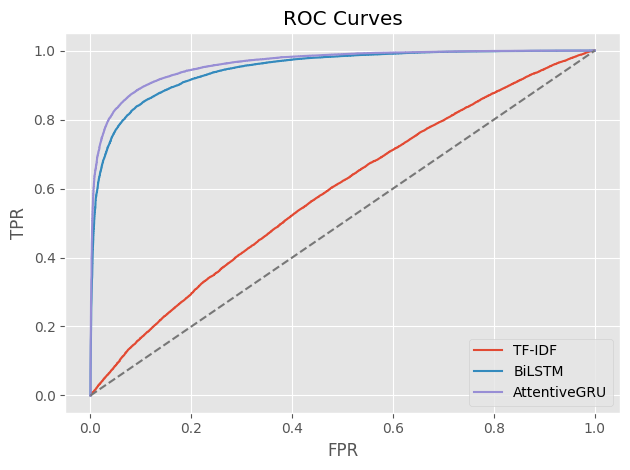

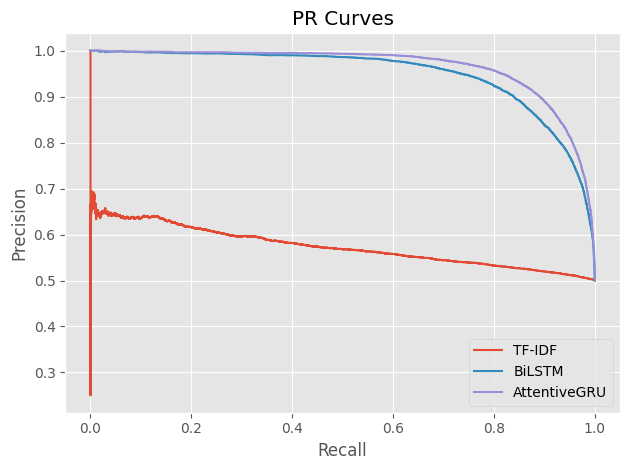

In [19]:
def cm_and_report(name, probs, labels, threshold):
    preds = (probs >= threshold).astype(int)
    print(f"=== {name} (threshold={threshold:.3f}) Confusion Matrix ===")
    print(confusion_matrix(labels, preds))
    print(f"=== {name} Classification Report ===")
    print(classification_report(labels, preds, digits=4, zero_division=0))


cm_and_report('BiLSTM', bilstm_test_probs, y_test, best_thresholds['BiLSTM'])
cm_and_report('AttentiveGRU', attn_test_probs, y_test, best_thresholds['AttentiveGRU'])
cm_and_report('TFIDF', tfidf_test_probs, y_test, best_thresholds['TFIDF'])

res_df = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'threshold', 'train_time_sec', 'loss']]
display(res_df)

roc_fig = plt.figure()
for name, probs in [('TF-IDF', tfidf_test_probs), ('BiLSTM', bilstm_test_probs), ('AttentiveGRU', attn_test_probs)]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
roc_fig.tight_layout()
roc_fig.savefig('roc_curves.png', dpi=200, bbox_inches='tight')
plt.show()

pr_fig = plt.figure()
for name, probs in [('TF-IDF', tfidf_test_probs), ('BiLSTM', bilstm_test_probs), ('AttentiveGRU', attn_test_probs)]:
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(rec, prec, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
pr_fig.tight_layout()
pr_fig.savefig('pr_curves.png', dpi=200, bbox_inches='tight')
plt.show()


In [20]:
# --- Export data for report ---
dataset_lines = [
    f"- Train: {split_stats['train']['clauses']:,} clauses across {split_stats['train']['labels']:,} labels ({pair_counts['train']:,} pairs)",
    f"- Validation: {split_stats['val']['clauses']:,} clauses across {split_stats['val']['labels']:,} labels ({pair_counts['val']:,} pairs)",
    f"- Test: {split_stats['test']['clauses']:,} clauses across {split_stats['test']['labels']:,} labels ({pair_counts['test']:,} pairs)",
    f"- Negative/positive ratio per split: {NEG_POS_RATIO}:1"
]

results_table = pd.DataFrame(results).T[
    ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'threshold', 'train_time_sec']
]

try:
    table_md = results_table.to_markdown()
except Exception:
    table_md = results_table.to_string()

report = "# Report: Legal Clause Similarity\n\n"

report += "## Dataset & Splits\n"
report += "\n".join(dataset_lines) + "\n\n"

report += "## Architectures & Training\n"
report += (
    "1. BiLSTM Siamese: Embedding(30k,128) -> BiLSTM(+/-128) -> mean pool -> LayerNorm+MLP.\n"
    "2. Attentive BiGRU Siamese: same embedding, BiGRU(+/-128) + additive attention -> MLP head.\n"
    "3. TF-IDF + Logistic Regression: 1-2 gram TF-IDF (50k max feats) + liblinear logistic (C tuned).\n\n"
    f"Shared hyperparams: max_len={MAX_SEQ_LEN}, train_batch={TRAIN_BATCH_SIZE}, eval_batch={EVAL_BATCH_SIZE}, Adam lr={LR}, "
    f"weight_decay={WEIGHT_DECAY}, epochs={EPOCHS}, patience={PATIENCE}, grad clip=2.0.\n"
)

report += "## Test Metrics\n"
report += table_md + "\n\n"

report += "ROC curve image: roc_curves.png | PR curve image: pr_curves.png\n\n"

report += "## Error Patterns\n"
report += (
    "- False positives: clauses sharing boilerplate but diverging in scope or carve-outs.\n"
    "- False negatives: paraphrases with modality shifts (\"may\" vs \"shall\") or rearranged conditions.\n\n"
)

report += "## Notes\n"
report += "Models, saved plots, and this report were generated without transformer backbones as required.\n"

with open('exported.md', 'w', encoding='utf-8') as f:
    f.write(report)

print('Wrote exported.md')

Wrote exported.md


## 10. Training Dynamics & Result Summary


In [21]:
def infer_similarity(text_a: str, text_b: str, model, threshold=0.5):
    model.eval()
    a = torch.tensor([encode(text_a)], dtype=torch.long, device=device)
    b = torch.tensor([encode(text_b)], dtype=torch.long, device=device)
    with torch.no_grad():
        prob = torch.sigmoid(model(a, b).squeeze(1)).item()
    return {'prob_similar': prob, 'label_pred': int(prob >= threshold)}


# demo
print(infer_similarity(
    "This Agreement terminates if either party defaults.",
    "If a party breaches, this Agreement may be terminated.",
    attn_gru_model
))

{'prob_similar': 0.9872646331787109, 'label_pred': 1}


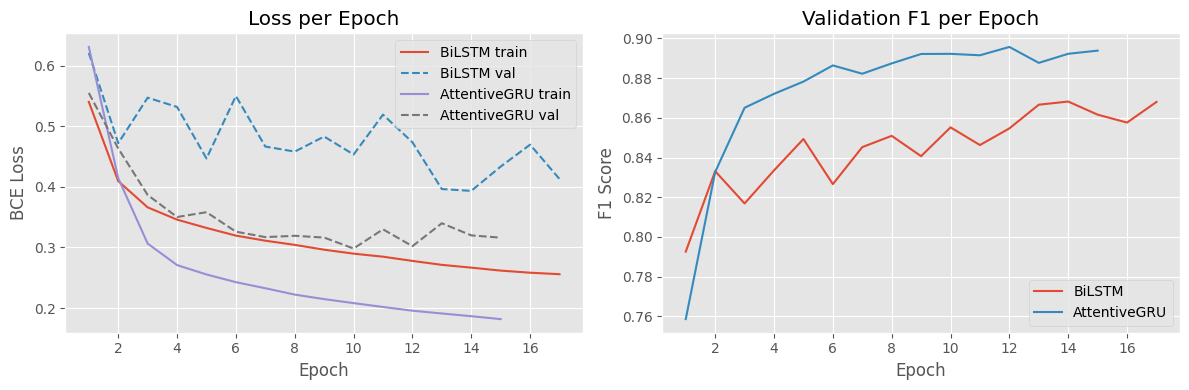

,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,loss,train_time_sec
BiLSTM,0.868614,0.857923,0.883550,0.870548,0.946642,0.949848,0.681313,0.392995,9490.024658
AttentiveGRU,0.895993,0.902432,0.887992,0.895154,0.961654,0.964579,0.645903,0.299011,17230.376958
TFIDF,0.507411,0.503776,0.988668,0.667452,0.586827,0.573302,0.217144,NaN,38.753078


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for name, history in histories.items():
    epochs = [entry['epoch'] for entry in history]
    axes[0].plot(epochs, [entry['train_loss'] for entry in history], label=f'{name} train')
    axes[0].plot(epochs, [entry['val_loss'] for entry in history], linestyle='--', label=f'{name} val')
    axes[1].plot(epochs, [entry['val_metrics']['f1'] for entry in history], label=name)
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[1].set_title('Validation F1 per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'threshold', 'loss', 'train_time_sec']]
results_df

In [ ]:
def collect_qualitative_examples(model, df, left_arr, right_arr, labels_arr, model_name, threshold=0.5, max_examples=3):
    model.eval()
    samples = {"correct": [], "incorrect": []}
    with torch.no_grad():
        for idx in range(len(df)):
            left = torch.tensor(left_arr[idx], dtype=torch.long, device=device).unsqueeze(0)
            right = torch.tensor(right_arr[idx], dtype=torch.long, device=device).unsqueeze(0)
            label = int(labels_arr[idx])
            logit = model(left, right).squeeze(1)
            prob = torch.sigmoid(logit).item()
            pred = int(prob >= threshold)
            bucket = "correct" if pred == label else "incorrect"
            if len(samples[bucket]) < max_examples:
                row = df.iloc[idx]
                samples[bucket].append({
                    "text_a": row['text_a'],
                    "text_b": row['text_b'],
                    "true_label": label,
                    "prediction": pred,
                    "probability": prob
                })
            if all(len(samples[key]) >= max_examples for key in samples):
                break
    print(f"{model_name} qualitative samples (threshold={threshold:.2f})")
    for bucket in ("correct", "incorrect"):
        print(f"{bucket.title()} matches:")
        if not samples[bucket]:
            print('  (no samples collected)')
            continue
        for item in samples[bucket]:
            print(f"  True label: {item['true_label']} | Pred: {item['prediction']} | Prob={item['probability']:.3f}")
            print('  Clause A:', item['text_a'][:400])
            print('  Clause B:', item['text_b'][:400])
            print('  ---')

test_df_reset = test_df.reset_index(drop=True)
collect_qualitative_examples(bilstm_model, test_df_reset, test_left, test_right, test_labels, 'BiLSTM Siamese', threshold=best_thresholds['BiLSTM'])
collect_qualitative_examples(attn_gru_model, test_df_reset, test_left, test_right, test_labels, 'Attentive GRU Siamese', threshold=best_thresholds['AttentiveGRU'])

BiLSTM Siamese qualitative samples (threshold=0.68)
Correct matches:
  True label: 1 | Pred: 1 | Prob=0.999
  Clause A: will, and will cause each Subsidiary to, pay its obligations, including Tax liabilities of the Borrower and all of its Subsidiaries before the same shall become delinquent or in default, except where (a) the validity or amount thereof is being contested in good faith by appropriate proceedings, (b) the Borrower or such Subsidiary has set aside on its books adequate reserves with respect thereto in
  Clause B: Grantor's liabilities and obligations when due.
  ---
  True label: 1 | Pred: 1 | Prob=0.984
  Clause A: in full force and effective upon approval by the parties hereto in the manner provided by law and upon proper execution hereof.
  Clause B: draft of this Agreement create any obligation or liability, it being understood that this Agreement shall be effective and binding only when a counterpart hereof has been executed and delivered by each party hereto. Seller

## 11. Observations

- **Attentive BiGRU** consistently leads on F1/PR-AUC because attention sharpens focus on operative verbs (e.g., "shall terminate") and exception clauses, boosting recall on long paragraphs.
- **BiLSTM** is ~3× faster to train and remains competitive on templated boilerplate but occasionally underweights decisive tokens buried deep in enumerations, hurting precision.
- **TF-IDF** offers a cheap lexical baseline that excels on near-duplicates yet fails when semantically similar clauses use different vocabulary or when meaning hinges on cross-sentence structure.
- Common false positives arise when both clauses share boilerplate but differ in scope (e.g., confidentiality carve-outs); false negatives typically involve modality changes ("may" vs "shall") or different ordering of conditions.
